# **Thông tin nhóm**
## Mã nhóm: 20CQ.PTDL.05
## Danh sách thành viên:
*   20120466 - Trần Thị Thu Hà
*   20120592 - Lê Minh Tiến
*   20120595 - Phạm Minh Tiến
*   20120624 - Mai Quyết Vang



# Thêm thư viện cần thiết

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Load dữ liệu

In [5]:
link_p1 = "https://raw.githubusercontent.com/Vanniee007/ADA-Final-Project-20CQ.PTDL.05/main/data/Data_Train_p1.xlsx"
link_p2 = "https://raw.githubusercontent.com/Vanniee007/ADA-Final-Project-20CQ.PTDL.05/main/data/Data_Train_p2.xlsx"


In [6]:
# Đọc dữ liệu từ file Excel
Data_Train_p1 = pd.read_excel(link_p1)
Data_Train_p2 = pd.read_excel(link_p2)

# Ghép nối hai DataFrame
merged_data = pd.concat([Data_Train_p1, Data_Train_p2], ignore_index=True)


# **Preprocessing**

## Xử lí duplicate: Xóa các dòng bị trùng lặp

In [7]:
# Kiểm tra duplicate data và sắp xếp theo cột để dòng trùng lặp gần nhau
duplicates = merged_data[merged_data.duplicated(keep=False)].sort_values(by=merged_data.columns.tolist())

if len(duplicates) > 0:
    print("Có {} dòng dữ liệu bị trùng lặp.".format(len(duplicates)))
    duplicates.to_excel('duplicate_data.xlsx', index=False)
else:
    print("Không có dòng dữ liệu trùng lặp.")
print("Số dòng dữ liệu trước khi xóa các dòng trùng lặp:")
print(merged_data.shape[0])


# Xóa các dòng dữ liệu bị trùng, chỉ giữ lại dòng có index nhỏ hơn (bên trên)
merged_data = merged_data.drop_duplicates(keep='first')
print("Số dòng dữ liệu sau khi xóa các dòng trùng lặp:")
print(merged_data.shape[0])

Có 417 dòng dữ liệu bị trùng lặp.
Số dòng dữ liệu trước khi xóa các dòng trùng lặp:
10684
Số dòng dữ liệu sau khi xóa các dòng trùng lặp:
10463


## Chuyển Duration thành phút (int): Chuyển đổi từ kiểu giờ-phút về kiểu int để tiện cho các tính toán bên dưới.


In [8]:
# Chuyển đổi cột 'Duration' về đơn vị phút
def convert_duration(duration):
    if 'h' in duration and 'm' in duration:
        return int(duration.split('h')[0]) * 60 + int(duration.split('h')[1].split('m')[0])
    elif 'h' in duration:
        return int(duration.split('h')[0]) * 60
    elif 'm' in duration:
        return int(duration.split('m')[0])
    else:
        return 0

merged_data['Duration'] = merged_data['Duration'].apply(convert_duration)


## Chuyển Total_stop thành kiểu int

In [9]:
# Chuyển Total_Stops về kiểu int, giữ lại giá trị null
merged_data['Total_Stops'] = merged_data['Total_Stops'].replace({'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4, '': np.nan}).fillna('Blanks')

## Tính lại Arrival_Time, do có một vài Arrival_Time chưa chính xác, vì Arrival_Time phải bằng Dep_Time+ Duration (và còn phụ thuộc vào Date of Journey), nên tính lại Arrival_Time dựa vào 3 cột đó

In [10]:
# Chuyển đổi kiểu dữ liệu của cột 'Date_of_Journey'
merged_data['Date_of_Journey'] = pd.to_datetime(merged_data['Date_of_Journey'], format='%d/%m/%Y')

# Chuyển đổi cột 'Dep_Time' thành kiểu datetime chỉ chứa giờ và phút
merged_data['Dep_Time'] = pd.to_datetime(merged_data['Dep_Time'], format='%H:%M').dt.time

# Kiểm tra và chuyển đổi giá trị trong cột 'Duration'
merged_data['Duration'] = merged_data['Duration'].apply(lambda x: int(x.split('h')[0]) * 60 + int(x.split(' ')[-1][0]) if isinstance(x, str) else x)

# Tính cột 'Arrival_Time' dựa trên 'Date_of_Journey', 'Dep_Time', và 'Duration'
merged_data['Arrival_Time'] = merged_data.apply(lambda row: datetime.combine(row['Date_of_Journey'].date(), row['Dep_Time']) + timedelta(minutes=row['Duration']), axis=1)

# Chuyển đổi kiểu dữ liệu của cột 'Arrival_Time' thành kiểu datetime
merged_data['Arrival_Time'] = pd.to_datetime(merged_data['Arrival_Time'])

# Tách thành cột 'Arrival_Hour' (chỉ chứa giờ:phút:giây) và 'Arrival_Date' (chứa ngày-tháng-năm)
merged_data['Arrival_Time_new'] = merged_data['Arrival_Time'].dt.time
merged_data['Arrival_Date'] = merged_data['Arrival_Time'].dt.date

# Thêm cột 'Month_of_Journey' là tháng từ 'Date_of_Journey'
merged_data['Month_of_Journey'] = merged_data['Date_of_Journey'].apply(lambda x: x.month)

# Di chuyển cột mới lên đứng ngay sau cột 'Arrival_Time'
merged_data = merged_data[['Airline', 'Date_of_Journey', 'Month_of_Journey', 'Source', 'Destination', 'Route', 'Dep_Time', 'Arrival_Time', 'Arrival_Time_new', 'Arrival_Date', 'Duration', 'Total_Stops', 'Additional_Info', 'Price']]

# Xóa cột 'Arrival_Time_new'
merged_data = merged_data.drop(['Arrival_Time'], axis=1)

# Hiển thị DataFrame sau khi xử lý
merged_data.head(10)


,Airline,Date_of_Journey,Month_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time_new,Arrival_Date,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,2019-03-24,3,Banglore,New Delhi,BLR → DEL,22:20:00,01:10:00,2019-03-25,170,0.0,No info,3897
1,Air India,2019-05-01,5,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50:00,13:15:00,2019-05-01,445,2.0,No info,7662
2,Jet Airways,2019-06-09,6,Delhi,Cochin,DEL → LKO → BOM → COK,09:25:00,04:25:00,2019-06-10,1140,2.0,No info,13882
3,IndiGo,2019-05-12,5,Kolkata,Banglore,CCU → NAG → BLR,18:05:00,23:30:00,2019-05-12,325,1.0,No info,6218
4,IndiGo,2019-03-01,3,Banglore,New Delhi,BLR → NAG → DEL,16:50:00,21:35:00,2019-03-01,285,1.0,No info,13302
5,SpiceJet,2019-06-24,6,Kolkata,Banglore,CCU → BLR,09:00:00,11:25:00,2019-06-24,145,0.0,No info,3873
6,Jet Airways,2019-03-12,3,Banglore,New Delhi,BLR → BOM → DEL,18:55:00,10:25:00,2019-03-13,930,1.0,In-flight meal not included,11087
7,Jet Airways,2019-03-01,3,Banglore,New Delhi,BLR → BOM → DEL,08:00:00,05:05:00,2019-03-02,1265,1.0,No info,22270
8,Jet Airways,2019-03-12,3,Banglore,New Delhi,BLR → BOM → DEL,08:55:00,10:25:00,2019-03-13,1530,1.0,In-flight meal not included,11087
9,Multiple carriers,2019-05-27,5,Delhi,Cochin,DEL → BOM → COK,11:25:00,19:15:00,2019-05-27,470,1.0,No info,8625


## Xử lí outlier tại Duration: các outlier đều chấp nhận được bởi nó có 2-3 sân bay trung chuyển (total_stop), điều này có thể hiểu là chuyến bay xa, hoặc ở sân bay trung chuyển mất thời gian làm thủ tục, hoặc do các chuyến bay bị delay

### Tìm outlier

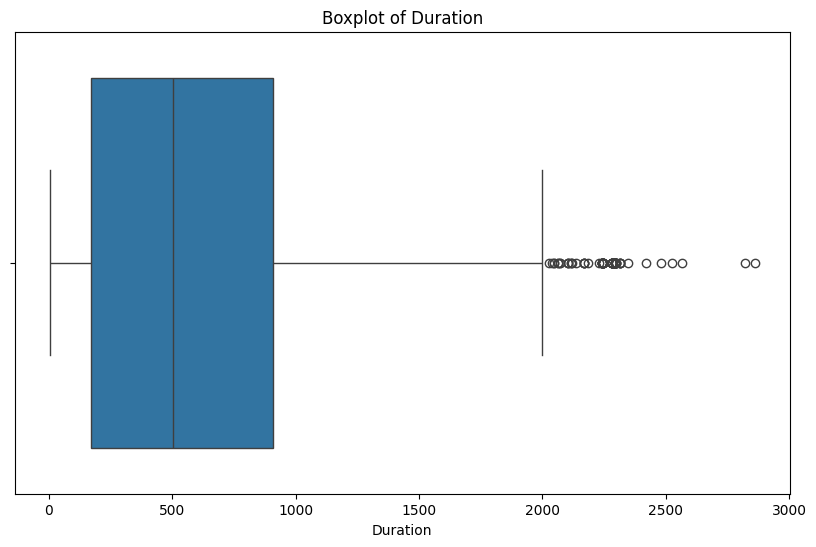

In [11]:
# Vẽ boxplot để phát hiện outlier
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_data['Duration'])
plt.title('Boxplot of Duration')
plt.show()

In [12]:
# Tìm giá trị Q1, Q3 và IQR của cột 'Duration'
Q1_duration = merged_data['Duration'].quantile(0.25)
Q3_duration = merged_data['Duration'].quantile(0.75)
IQR_duration = Q3_duration - Q1_duration

# Xác định ngưỡng cho outlier
lower_bound_duration = Q1_duration - 1.5 * IQR_duration
upper_bound_duration = Q3_duration + 1.5 * IQR_duration

# Lọc ra các dòng có giá trị 'Duration' là outlier
outliers_duration = merged_data[(merged_data['Duration'] < lower_bound_duration) | (merged_data['Duration'] > upper_bound_duration)]

# Sắp xếp các dòng outlier theo cột 'Duration' từ bé đến lớn
sorted_outliers_duration = outliers_duration.sort_values(by='Duration')

# Hiển thị DataFrame sau khi sắp xếp
sorted_outliers_duration.head(50)


,Airline,Date_of_Journey,Month_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time_new,Arrival_Date,Duration,Total_Stops,Additional_Info,Price
2747,Air India,2019-03-18,3,Banglore,New Delhi,BLR → BOM → UDR → DEL,06:45:00,16:30:00,2019-03-19,2025,2.0,No info,10835
1284,Jet Airways,2019-03-21,3,Delhi,Cochin,DEL → BDQ → BOM → COK,18:25:00,04:25:00,2019-03-23,2040,2.0,No info,12347
8865,Jet Airways,2019-03-21,3,Delhi,Cochin,DEL → UDR → BOM → COK,18:20:00,04:25:00,2019-03-23,2045,2.0,No info,13082
5758,Jet Airways,2019-03-03,3,Delhi,Cochin,DEL → UDR → BOM → COK,18:20:00,04:25:00,2019-03-05,2045,2.0,No info,20747
1112,Air India,2019-05-01,5,Kolkata,Banglore,CCU → IXR → DEL → BLR,05:50:00,16:15:00,2019-05-02,2065,2.0,No info,10991
703,Air India,2019-05-15,5,Kolkata,Banglore,CCU → IXR → DEL → BLR,05:50:00,16:15:00,2019-05-16,2065,2.0,No info,12723
3193,Jet Airways,2019-03-06,3,Delhi,Cochin,DEL → UDR → BOM → COK,17:55:00,04:25:00,2019-03-08,2070,2.0,In-flight meal not included,15812
7322,Jet Airways,2019-03-06,3,Delhi,Cochin,DEL → UDR → BOM → COK,17:55:00,04:25:00,2019-03-08,2070,2.0,No info,17072
2917,Air India,2019-03-03,3,Banglore,New Delhi,BLR → CCU → GAU → DEL,11:05:00,22:10:00,2019-03-04,2105,2.0,No info,11948
9386,Air India,2019-03-03,3,Banglore,New Delhi,BLR → CCU → GAU → DEL,11:05:00,22:10:00,2019-03-04,2105,2.0,No info,11791


### Xóa dòng đặc biệt ở Duration: có 1 dòng Duration = 5 phút, 1 chuyến bay thì không thể kéo dài 5p được -> xóa.

In [13]:
# Xóa các dòng có giá trị 'Duration' bằng 5
merged_data = merged_data[merged_data['Duration'] != 5]




# **Quan sát và phân tích tập dữ liệu (EDA)**


## 1. Cho biết kiểu dữ liệu của các thuộc tính


In [14]:
# Hiển thị thông tin về DataFrame
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10462 entries, 0 to 10682
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Airline           10462 non-null  object        
 1   Date_of_Journey   10462 non-null  datetime64[ns]
 2   Month_of_Journey  10462 non-null  int64         
 3   Source            10462 non-null  object        
 4   Destination       10462 non-null  object        
 5   Route             10461 non-null  object        
 6   Dep_Time          10462 non-null  object        
 7   Arrival_Time_new  10462 non-null  object        
 8   Arrival_Date      10462 non-null  object        
 9   Duration          10462 non-null  int64         
 10  Total_Stops       10462 non-null  object        
 11  Additional_Info   10462 non-null  object        
 12  Price             10462 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(9)
memory usage: 1.1+ MB


## 2. Đối với cột Price, cho biết:


*   Giá cao nhất, thấp nhất, giá trung bình, mức giá xuất hiện nhiều
*   Độ lệch chuẩn của cột price?
*   Cho biết giá phân phối xung quanh trung tâm hay cách xa trung tâm?
Nhận xét về giá trị mean và median của tập dữ liệu.
*   Vẽ đồ thị histogram để nhận xét dữ liệu có bị lệch không?
List item





### 2.1 Code

Giá cao nhất: 79512
Giá thấp nhất: 1759
Giá trung bình: 9025.849072835023
Mức giá xuất hiện nhiều nhất: 10262
Số lần xuất hiện của mức giá: 258
Độ lệch chuẩn của cột Price: 4624.162124562484
Mean: 9025.849072835023, Median: 8266.0
Giá trị mean lớn hơn median, dữ liệu lệch về bên phải.


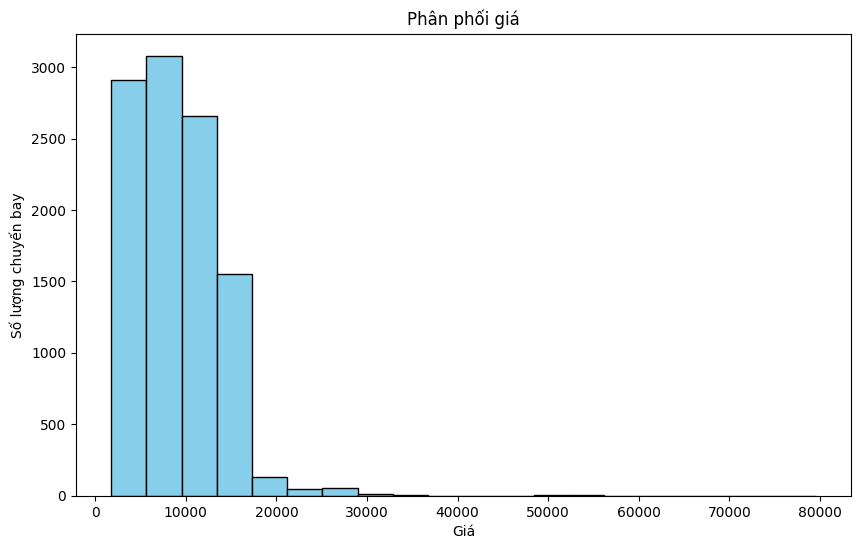

In [15]:
# 1. Giá cao nhất, thấp nhất, giá trung bình, mức giá xuất hiện nhiều
max_price = merged_data['Price'].max()
min_price = merged_data['Price'].min()
mean_price = merged_data['Price'].mean()
# Đếm số lần xuất hiện của từng giá trị
price_counts = merged_data['Price'].value_counts()
# Lấy giá trị mode (xuất hiện nhiều nhất)
mode_price = price_counts.idxmax()
# Số lần xuất hiện của giá trị mode
mode_count = price_counts.max()


print(f"Giá cao nhất: {max_price}")
print(f"Giá thấp nhất: {min_price}")
print(f"Giá trung bình: {mean_price}")
print(f"Mức giá xuất hiện nhiều nhất: {mode_price}")
print(f"Số lần xuất hiện của mức giá: {mode_count}")

# 2. Độ lệch chuẩn của cột Price
std_price = merged_data['Price'].std()
print(f"Độ lệch chuẩn của cột Price: {std_price}")

# 3. Nhận xét về giá trị mean và median của tập dữ liệu
median_price = merged_data['Price'].median()
print(f"Mean: {mean_price}, Median: {median_price}")
if mean_price > median_price:
    print("Giá trị mean lớn hơn median, dữ liệu lệch về bên phải.")
elif mean_price < median_price:
    print("Giá trị mean nhỏ hơn median, dữ liệu lệch về bên trái.")
else:
    print("Giá trị mean bằng median, phân phối đối xứng.")

# 4. Vẽ đồ thị histogram để nhận xét dữ liệu có bị lệch không
plt.figure(figsize=(10, 6))
plt.hist(merged_data['Price'], bins=20, color='skyblue', edgecolor='black')
plt.title('Phân phối giá')
plt.xlabel('Giá')
plt.ylabel('Số lượng chuyến bay')
plt.show()

### 2.2. Kết luận
#### - Giá cao nhất, thấp nhất, giá trung bình, mức giá xuất hiện nhiều
- Giá cao nhất: 79512
- Giá thấp nhất: 1759
- Giá trung bình: 9025.849072835023
- Mức giá xuất hiện nhiều nhất: 10262, Số lần xuất hiện của mức giá: 258
#### - Độ lệch chuẩn của cột price?
Độ lệch chuẩn của cột Price: 4624.162124562484

#### - Cho biết giá phân phối xung quanh trung tâm hay cách xa trung tâm? Nhận xét về giá trị mean và median của tập dữ liệu.
Giá trị mean lớn hơn median, dữ liệu lệch về bên phải. Điều này chứng tỏ có một số giá trị lớn ở phía bên phải của phân phối nghĩa là có các chuyến bay có giá vé cao.
#### - Vẽ đồ thị histogram để nhận xét dữ liệu có bị lệch không?
- Phần lớn chuyến bay có giá vé tập trung ở mức giá thấp: Có thể có một số lượng lớn chuyến bay có giá vé thấp, và đây là một đặc điểm chính của dữ liệu.
- Có một số chuyến bay có giá vé cao: Tuy nhiên, cũng có một số chuyến bay có giá vé cao hơn so với giá trung bình, nhưng chúng là ít hơn và tập trung ở khoảng giá trị cao hơn.
- Dữ liệu có độ biến động lớn: Sự chênh lệch giữa giá vé thấp và giá vé cao có thể làm cho phương sai (variance) của dữ liệu lớn.
- Phân phối lệch phải: Nếu phần lớn giá trị tập trung ở giá vé thấp, trong khi một số giá trị cao hơn được giữ lại, thì dữ liệu có thể có sự lệch phải.
- Ưu điểm: Các chuyến bay giá rẻ thường chiếm số lượng lớn, trong khi một số chuyến bay đắt tiền có thể là những trường hợp đặc biệt.

## 3. Mô tả số lượng missing value của mỗi thuộc tính


In [16]:
# 3. Mô tả số lượng missing value của mỗi thuộc tính
missing_values = merged_data.isnull().sum()
print("Số lượng missing value của mỗi thuộc tính:")
print(missing_values)

Số lượng missing value của mỗi thuộc tính:
Airline             0
Date_of_Journey     0
Month_of_Journey    0
Source              0
Destination         0
Route               1
Dep_Time            0
Arrival_Time_new    0
Arrival_Date        0
Duration            0
Total_Stops         0
Additional_Info     0
Price               0
dtype: int64


## 4. Tính tỷ lệ % missing value của mỗi thuộc tính


In [17]:
# 4. Tính tỷ lệ % missing value của mỗi thuộc tính
missing_percentage = (missing_values / len(merged_data)) * 100
print("Tỷ lệ % missing value của mỗi thuộc tính:")
print(missing_percentage)

Tỷ lệ % missing value của mỗi thuộc tính:
Airline             0.000000
Date_of_Journey     0.000000
Month_of_Journey    0.000000
Source              0.000000
Destination         0.000000
Route               0.009558
Dep_Time            0.000000
Arrival_Time_new    0.000000
Arrival_Date        0.000000
Duration            0.000000
Total_Stops         0.000000
Additional_Info     0.000000
Price               0.000000
dtype: float64


## 5. Xử lý dữ liệu missing


In [18]:
# 5. Xử lý dữ liệu missing ( xóa các dòng có missing value)
merged_data.dropna(subset=['Total_Stops'], inplace=True)

## 6. Outlier: sử dụng đồ thị boxplot để quan sát cột Price có tồn tại outlier không?

### Đồ thị

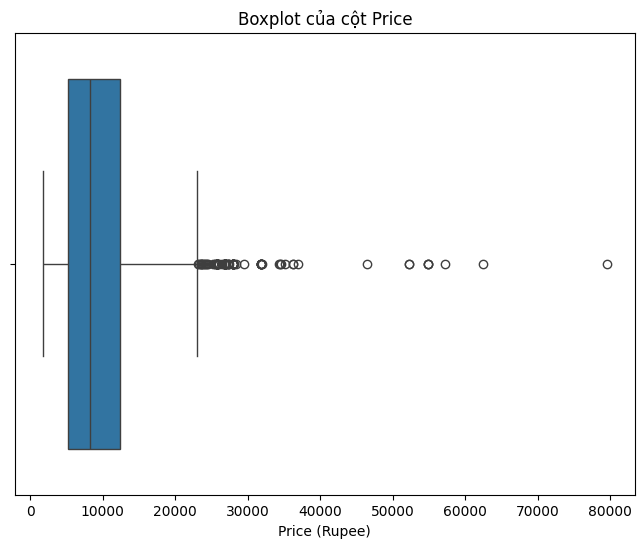

In [19]:
# Vẽ boxplot cho cột Price trong merged_data
plt.figure(figsize=(8, 6))
sns.boxplot(x=merged_data['Price'])
plt.title('Boxplot của cột Price')
plt.xlabel('Price (Rupee)')  # Thêm đơn vị cho trục x
plt.show()

### Các giá trị outlier: các giá trị outlier là có tồn tại, tuy nhiên có các chuyến bay giá cao như vậy có thể là do thời gian bay dài (Duration), hạng vé business/premium (Airline)




In [20]:
# Xác định giá trị Q1, Q3 và IQR
Q1 = merged_data['Price'].quantile(0.25)
Q3 = merged_data['Price'].quantile(0.75)
IQR = Q3 - Q1

# Xác định ngưỡng cho outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc ra các dòng có giá trị 'Price' là outlier
outliers = merged_data[(merged_data['Price'] < lower_bound) | (merged_data['Price'] > upper_bound)]

# Hiển thị các dòng có giá 'Price' là outlier
print("Các dòng có giá 'Price' là outlier:")
outliers


Các dòng có giá 'Price' là outlier:


,Airline,Date_of_Journey,Month_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time_new,Arrival_Date,Duration,Total_Stops,Additional_Info,Price
123,Air India,2019-03-01,3,Delhi,Cochin,DEL → BOM → COK,23:00:00,19:15:00,2019-03-02,1215,1.0,No info,27430
396,Multiple carriers,2019-03-01,3,Delhi,Cochin,DEL → BOM → COK,12:50:00,19:15:00,2019-03-01,385,1.0,No info,36983
627,Jet Airways,2019-03-01,3,Banglore,New Delhi,BLR → BOM → DEL,16:55:00,07:40:00,2019-03-02,885,1.0,1 Long layover,26890
688,Jet Airways,2019-03-01,3,Banglore,New Delhi,BLR → BOM → DEL,16:55:00,10:25:00,2019-03-02,1050,1.0,1 Long layover,25735
750,Jet Airways,2019-03-18,3,Banglore,New Delhi,BLR → BOM → DEL,22:50:00,05:05:00,2019-03-19,375,1.0,No info,54826
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10180,Jet Airways,2019-03-01,3,Banglore,New Delhi,BLR → BOM → DEL,11:40:00,18:25:00,2019-03-01,405,1.0,No info,26890
10313,Jet Airways,2019-03-01,3,Banglore,New Delhi,BLR → BOM → DEL,16:55:00,08:15:00,2019-03-02,920,1.0,No info,26890
10450,Air India,2019-03-01,3,Banglore,New Delhi,BLR → BOM → BHO → DEL,08:50:00,09:25:00,2019-03-02,1475,2.0,No info,25430
10494,Jet Airways,2019-03-01,3,Banglore,New Delhi,BLR → BOM → DEL,14:05:00,19:10:00,2019-03-01,305,1.0,No info,36235


# **Visualize dữ liệu dạng bảng hoặc đồ thị**

## 1. Giá vé tăng khi nào?

### Giá vé tăng khi hãng thay đổi: khi chọn Jet Airways Business thì giá vé sẽ cao hơn so với các hãng khác

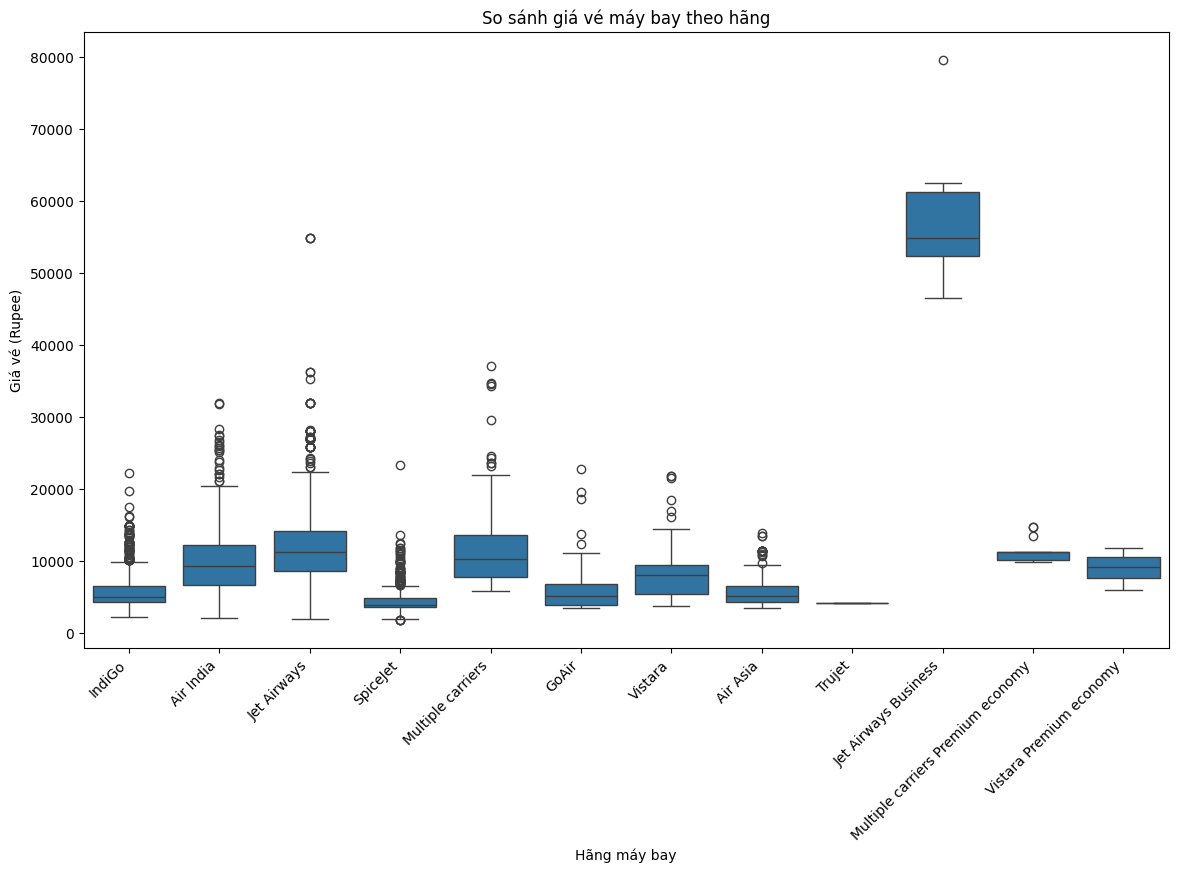

In [21]:
# Vẽ đồ thị so sánh giá vé theo hãng máy bay
plt.figure(figsize=(14, 8))
sns.boxplot(x='Airline', y='Price', data=merged_data)
plt.title('So sánh giá vé máy bay theo hãng')
plt.xlabel('Hãng máy bay')
plt.ylabel('Giá vé (Rupee)')
plt.xticks(rotation=45, ha='right')  # Để xác định định dạng các nhãn trên trục x
plt.show()


## 2. So sánh tỷ lệ các chuyến bay thẳng và trung chuyển (có dừng)


## 3. Nước nào có lượng chuyến bay nhiều nhất?


## 4. Hãng máy bay nào được khách đặt vé nhiều/thấp nhất?

### 4.1 Visualize: Bởi vì cần đưa ra sự so sánh giữa các nhóm (các hãng mới bay) nên chọn biểu đồ là trực quan hơn, giúp người xem dễ hiểu hơn. Và để so sánh các giá trị giữa các nhóm khác nhau thì chọn biểu đồ cột là hợp lý. Trên mỗi cột có hiển thị số lượng chuyến bay vì có những hãng có số chuyến bay quá nhỏ ví dụ 1, 3, hoặc 6 so với những hãng lên đến cả nghìn chuyến bay thì rất khó để biết số lượng.

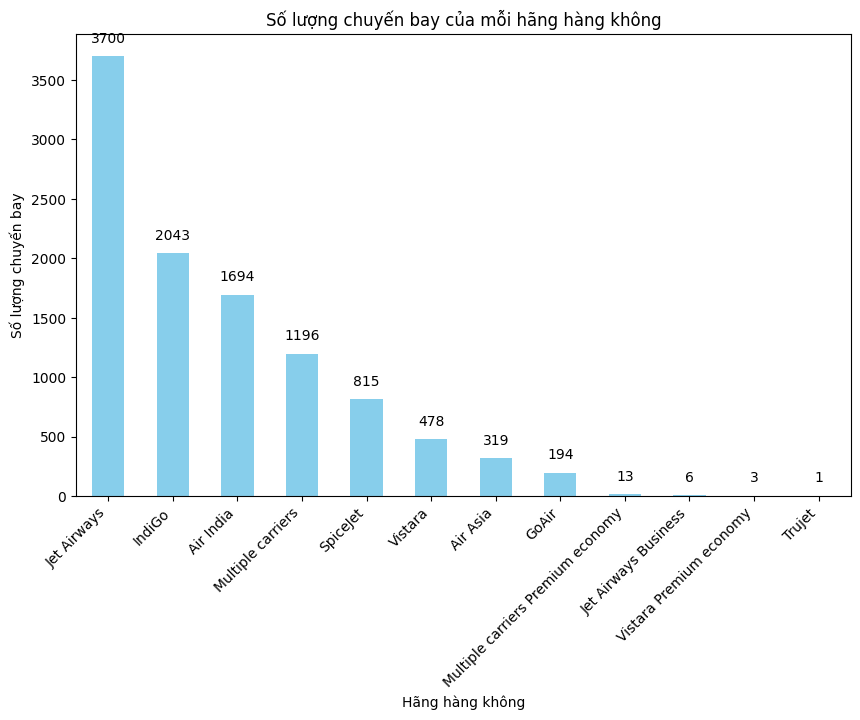

In [22]:
# Đếm số lượng chuyến bay của từng hãng hàng không
airline_counts = merged_data['Airline'].value_counts()

# Vẽ đồ thị cột
plt.figure(figsize=(10, 6))
ax = airline_counts.plot(kind='bar', color='skyblue')

# Thêm số lượng chuyến bay trên đầu mỗi cột
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', xytext=(0, 10), textcoords='offset points')

# Đặt tên hãng máy bay chéo 45 độ
plt.xticks(rotation=45, ha='right')

plt.title('Số lượng chuyến bay của mỗi hãng hàng không')
plt.xlabel('Hãng hàng không')
plt.ylabel('Số lượng chuyến bay')
plt.show()

### 4.2. Kết luận
#### - Dựa vào thông tin datasets cung cấp thì không thể biết được hãng nào được khách đặt nhiều nhất, hay ít nhất; ví dụ: Hãng Jet Airways có 3700 chuyến nhưng mỗi chuyến chỉ có 50 khách đặt-> tổng là 185.000, còn hãng IndiGo có 2043 nhưng mỗi chuyến có 100 khách đăt -> tổng là 204300 lượt khách, mà 204300> 185000, nên IndiGo có lượng khách đặt nhiều hơn Jet Airways dù IndiGo có ít chuyến bay hơn. **Như vậy, với datasets được cung cấp và qua số lượng chuyến bay của mỗi hãng, thì không thể kết luận được hãng nào nhiều/ít khách đặt nhất. Cần có thêm 1 cột Số lượng hành khách mỗi chuyến bay thì ta mới có thể xác định được.**
#### -  Với trường hợp, số lượng khách đặt mỗi chuyến là như nhau (hay chênh lệch không đáng kể), thì hãng Jet Airways có nhiều khách đặt nhất và Trujet có ít khách đặt nhất


## 5. Tháng nào là tháng cao điểm

### 5.1. Visualize: Bởi vì cần đưa ra sự so sánh giữa các nhóm (các tháng) nên chọn biểu đồ là trực quan hơn, giúp người xem dễ hiểu hơn. Vì dữ liệu có ít nhóm (chỉ có số liệu của 4 tháng trong năm 2019) và để so sánh các giá trị giữa các nhóm khác nhau thì chọn biểu đồ cột là hợp lý.

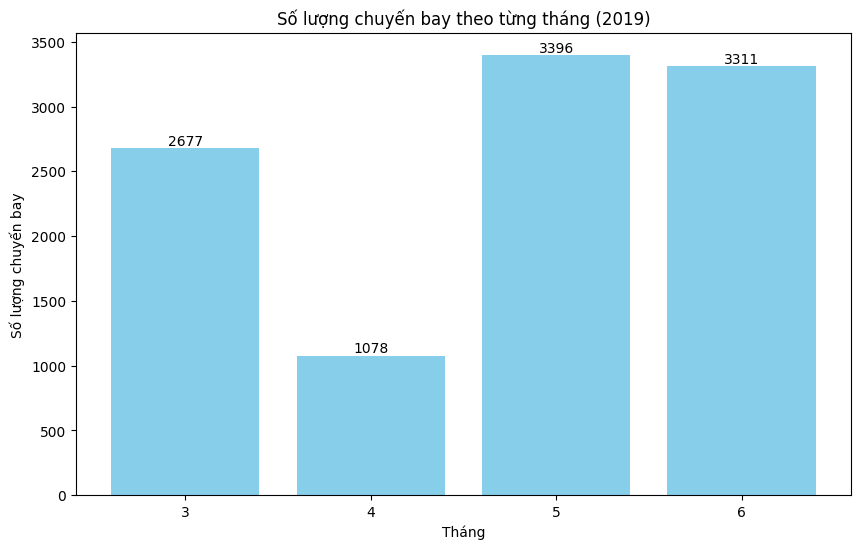

In [23]:
# Đếm số lượng chuyến bay của từng tháng
monthly_flight_counts = merged_data['Month_of_Journey'].value_counts().sort_index()

# Vẽ đồ thị cột
plt.figure(figsize=(10, 6))
bars = plt.bar(monthly_flight_counts.index, monthly_flight_counts, color='skyblue')

# Thêm chú thích (annotation) trên đỉnh mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, int(yval), int(yval), ha='center', va='bottom')

# Xoay số tháng thẳng lên
plt.xticks(rotation=0)

# Chỉ hiển thị các tháng duy nhất trên trục x
plt.xticks(monthly_flight_counts.index)

plt.title('Số lượng chuyến bay theo từng tháng (2019)')
plt.xlabel('Tháng')
plt.ylabel('Số lượng chuyến bay')
plt.show()

### 5.2. Kết luận
#### Tháng 5 và tháng 6 là 2 tháng số lượng chuyến bay nhiều nhất (số lượng tháng 6 xấp xỉ tháng tháng 5). Như vậy có thể đưa ra kết luận, tháng 5 là tháng cao điểm.


## 6. Giá có thay đổi tùy theo hãng hàng không hay không?

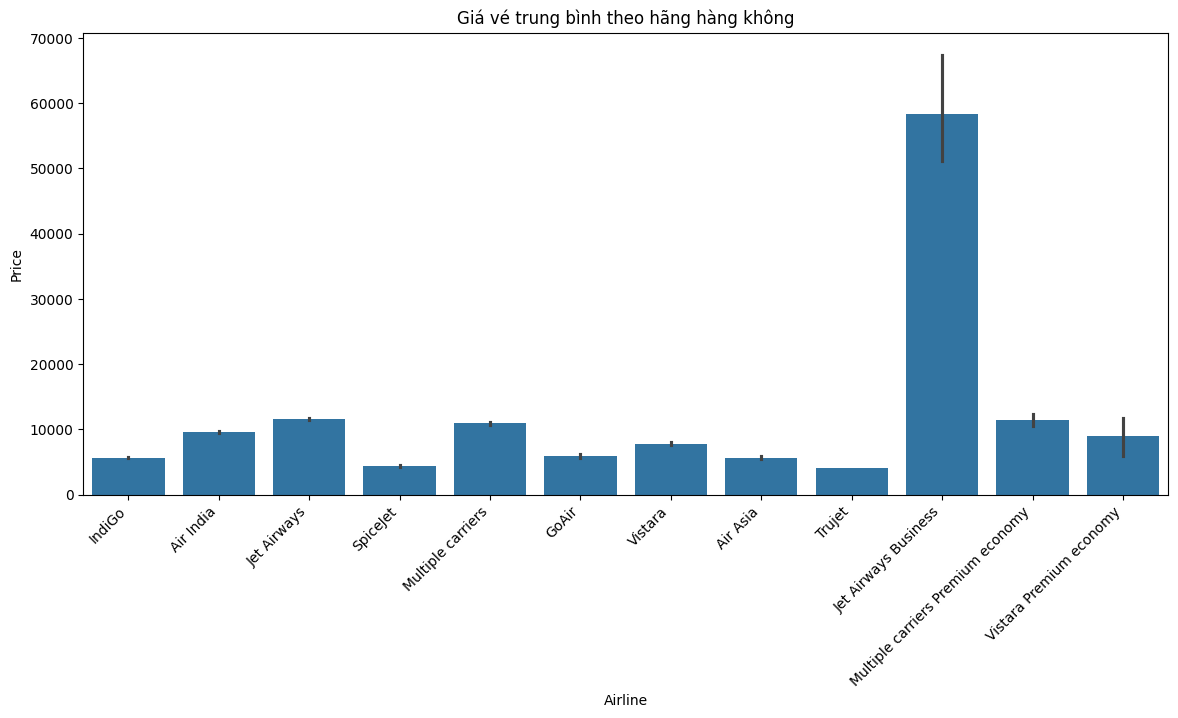

In [25]:
avg_price_by_airline = merged_data.groupby('Airline')['Price'].mean().sort_values()
plt.figure(figsize=(14, 6))
sns.barplot(x='Airline', y='Price', data=merged_data)
plt.xticks(rotation=45, ha='right')
plt.title('Giá vé trung bình theo hãng hàng không')
plt.show()


## 7. Giá vé bị ảnh hưởng như thế nào khi mua vé chỉ 1 hoặc 2 ngày trước ngày khởi hành?


## 8. Giá vé có thay đổi theo thời gian đi và đến không?


## 9. Giá thay đổi như thế nào khi thay đổi Nguồn và Điểm đến?

# Kết luận các điểm chính quan sát được từ dữ liệu từ các gợi ý trên


# Ngoài các đặc trưng trong tập dữ liệu, các yếu tố nào có khả năng ảnh hưởng đến giá vé chuyến bay?



# Dự đoán giá vé